In [56]:
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
import matplotlib.pyplot as plt
from nemosis import static_table, dynamic_data_compiler
import plotly.express as px

raw_data_cache = '/Volumes/T7/NEMO_data'

pd.set_option('display.max_columns', None)

# Methodology

Aim: Do a profit maximisation test for a single power station for a single auction

RD requires bids + dispatch load. It also requires finding the supply bids for all other firms.
MC requires bids + variable fuel costs


NEW:
1. As bids are on a per power station basis, adjust!

OLD:
1. Find MC estimates
2. Group units together by the firms that control them, including the firms's daily declared capacity
3. Create a total marginal cost function which represents the cost curve for all of a firm's generating units, stacked from lowest to highest cost. This creates a stepwise increasing function where: X-axis is cumulative MW across all units, Y-axis is marginal cost ($/MWh), each step represents a different generating unit. Width of step = unit's capacity. Height of step = unit's marginal cost
4. Taking only units that are verified to be "on-line" and operating during that hour
5. Subtracting the day-ahead scheduled quantity to center the function around 0
6. Including only natural gas and coal units that can respond quickly (excluding nuclear, wind, hydro)

#Step 1: MC estimates
Black coal: ~$41-101/MWh
Brown coal: ~$12-13/MWh
Wind/Solar: $0-1/MWh

Methodology:
1. Fuel cost range: 
2. Heat rate
3. Variable O&M (Operations and Maintenance)

Note: 
1. This includes a big assumption that MC is the same across every firm for each fuel type, which is not true!
2. For coal, it would be good to include a shutdown cost - I don't want to arbitrarily limit it like Hortaçsu as emperically coal firms are choosing to shut down

MC estimates:
X-axis: Cumulative quantity of electricity
Y-Axis: Price
MC:
Black coal: ~$41-101/MWh
Brown coal: ~$12-13/MWh
Natural Gas: $60-80/MWh

In [2]:
cost_estimates = {
    "Brown Coal": 12.5,       # Range $12–13 => Midpoint ~12.5
    "Black Coal": 71,         # Range $41–101 => Midpoint ~71
    "Natural Gas": 70,        # Range $60–80 => Midpoint ~70
    "Kerosene": 300,          # Range $200–400 => Midpoint ~300
    "Water": 10     # Range $0–20 => Midpoint ~10
#     "New Large-Scale Hydro": 95  # Range $40–150 => Midpoint ~95
}

In [3]:
# Required to join DUIDs to firm names 
generator_info_df = static_table(table_name='Generators and Scheduled Loads', 
                              raw_data_location=raw_data_cache,
                              update_static_file=False)
generator_info_df

INFO: Retrieving static table Generators and Scheduled Loads


,Participant,Station Name,Region,Dispatch Type,Category,Classification,Fuel Source - Primary,Fuel Source - Descriptor,Technology Type - Primary,Technology Type - Descriptor,Aggregation,DUID
0,South Australian Water Corporation,Adelaide Desalination Plant,SA1,Generating Unit,Market,Scheduled,Battery storage,Grid,Storage,Battery and Inverter,Y,ADPBA1G
1,South Australian Water Corporation,Adelaide Desalination Plant,SA1,Load,Market,Scheduled,Battery storage,Grid,Storage,Battery and Inverter,Y,ADPBA1L
2,South Australian Water Corporation,Adelaide Desalination Plant,SA1,Generating Unit,Market,Non-Scheduled,Hydro,Water,Renewable,Run of River,Y,ADPMH1
3,South Australian Water Corporation,Adelaide Desalination Plant,SA1,Generating Unit,Market,Semi-Scheduled,Solar,Solar,Renewable,Photovoltaic Tracking Flat panel,Y,ADPPV1
4,South Australian Water Corporation,Adelaide Desalination Plant,SA1,Generating Unit,Market,Non-Scheduled,Solar,Solar,Renewable,Photovoltaic Flat panel,Y,ADPPV2
...,...,...,...,...,...,...,...,...,...,...,...,...
527,Tailem Bend II Project Company Pty Ltd as trus...,Tailem Bend 2 Hybrid Renewable Power Station,SA1,Bidirectional Unit,Market,Scheduled,Battery storage,Grid,Storage,Battery and Inverter,Y,TB2B1
528,AGL Macquarie Pty Limited,Broken Hill Battery Energy Storage System,NSW1,Bidirectional Unit,Market,Scheduled,Battery storage,Grid,Storage,Battery and Inverter,Y,BHB1
529,AGL SA Generation Pty Limited,Torrens Island BESS,SA1,Bidirectional Unit,Market,Scheduled,Battery storage,Grid,Storage,Battery and Inverter,Y,TIB1
530,Capital Battery Pty Ltd as Trustee for Capital...,Capital Battery,NSW1,Load,Market,Scheduled,Battery storage,Grid,Storage,Battery and Inverter,Y,CAPBES1


# Find the marginal cost function and inelastic demand

In [4]:
# This is the table showing what electricity has been actually dispatched
dispatch_load_df = dynamic_data_compiler(start_time='2021/03/01 00:00:00',
                                   end_time='2021/04/10 00:00:00',
                                   table_name='DISPATCHLOAD',
                                   raw_data_location=raw_data_cache)
dispatch_load_df

INFO: Compiling data for table DISPATCHLOAD
INFO: Returning DISPATCHLOAD.


,SETTLEMENTDATE,DUID,INTERVENTION,DISPATCHMODE,AGCSTATUS,INITIALMW,TOTALCLEARED,RAMPDOWNRATE,RAMPUPRATE,LOWER5MIN,LOWER60SEC,LOWER6SEC,RAISE5MIN,RAISE60SEC,RAISE6SEC,LOWERREG,RAISEREG,AVAILABILITY,RAISEREGENABLEMENTMAX,RAISEREGENABLEMENTMIN,LOWERREGENABLEMENTMAX,LOWERREGENABLEMENTMIN,SEMIDISPATCHCAP
0,2021-03-01 00:05:00,AGLHAL,0,0,0,0.00000,0.00000,720.00,720.00,0.0,0.0,0.00000,0.0000,0.0000,0.0000,0.0,0.0,175.00000,0.00,0.0,0.00,0.0,0
1,2021-03-01 00:05:00,AGLSOM,0,0,0,0.00000,0.00000,480.00,480.00,0.0,0.0,0.00000,0.0000,0.0000,0.0000,0.0,0.0,160.00000,0.00,0.0,0.00,0.0,0
2,2021-03-01 00:05:00,ANGAST1,0,0,0,0.00000,0.00000,840.00,840.00,0.0,0.0,0.00000,0.0000,0.0000,0.0000,0.0,0.0,40.00000,0.00,0.0,0.00,0.0,0
3,2021-03-01 00:05:00,APD01,0,0,0,0.00000,0.00000,0.00,0.00,0.0,0.0,0.00000,0.0001,0.0001,0.0001,0.0,0.0,0.00000,0.00,0.0,0.00,0.0,0
4,2021-03-01 00:05:00,ARWF1,0,0,0,162.50000,161.88836,600.00,1200.00,0.0,0.0,0.00000,0.0000,0.0000,0.0000,0.0,0.0,161.88836,0.00,0.0,0.00,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914971,2021-04-10 00:00:00,YENDWF1,0,0,0,11.84000,11.49800,1680.00,1680.00,0.0,0.0,0.00000,0.0000,0.0000,0.0000,0.0,0.0,11.49800,0.00,0.0,0.00,0.0,0
914972,2021-04-10 00:00:00,YWPS1,0,0,0,0.00000,0.00000,180.00,180.00,0.0,0.0,0.00000,0.0000,0.0000,0.0000,0.0,0.0,0.00000,340.25,250.0,340.25,250.0,0
914973,2021-04-10 00:00:00,YWPS2,0,0,0,0.00000,0.00000,180.00,180.00,0.0,0.0,0.00000,0.0000,0.0000,0.0000,0.0,0.0,0.00000,355.25,250.0,355.25,250.0,0
914974,2021-04-10 00:00:00,YWPS3,0,0,1,389.87469,390.00000,180.00,180.00,0.0,0.0,0.00000,0.0000,0.0000,0.0000,0.0,0.0,390.00000,385.00,250.0,385.00,250.0,0


In [6]:
# We will now merge the dispatch table with info from the Generator table
# Perform an outer join to ensure we keep all DUIDs and settlement dates
merged_dispatch_with_units_df = pd.merge(dispatch_load_df[['SETTLEMENTDATE', 'DUID']], generator_info_df, on="DUID", how="outer")

# Now merge with the full dispatch_load dataset to bring all the fields together
working_dispatch_df = pd.merge(merged_dispatch_with_units_df,dispatch_load_df, on=["DUID", "SETTLEMENTDATE"], how="outer")

In [7]:
working_dispatch_df.describe()

,SETTLEMENTDATE,INTERVENTION,DISPATCHMODE,AGCSTATUS,INITIALMW,TOTALCLEARED,RAMPDOWNRATE,RAMPUPRATE,LOWER5MIN,LOWER60SEC,LOWER6SEC,RAISE5MIN,RAISE60SEC,RAISE6SEC,LOWERREG,RAISEREG,AVAILABILITY,RAISEREGENABLEMENTMAX,RAISEREGENABLEMENTMIN,LOWERREGENABLEMENTMAX,LOWERREGENABLEMENTMIN,SEMIDISPATCHCAP
count,4067136,4067136.0,4.067136e+06,4.067136e+06,4.067136e+06,4.067136e+06,4.067136e+06,4.067136e+06,4.067136e+06,4.067136e+06,4.067136e+06,4.067136e+06,4.067136e+06,4.067136e+06,4.067136e+06,4.067136e+06,4.067136e+06,4.067136e+06,4.067136e+06,4.067136e+06,4.067136e+06,4.067136e+06
mean,2021-03-21 00:04:32.362272256,0.0,7.983259e-02,2.124426e-01,5.808672e+01,5.809747e+01,1.829601e+03,1.903842e+03,7.065678e-01,1.111528e+00,8.569808e-01,1.288888e+00,1.713207e+00,1.700844e+00,6.061170e-01,6.378338e-01,9.824922e+01,7.058542e+01,3.778798e+01,7.094539e+01,3.799326e+01,3.275425e-02
min,2021-03-01 00:05:00,0.0,0.000000e+00,0.000000e+00,-6.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2021-03-11 00:05:00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.400000e+02,2.977500e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2021-03-21 00:05:00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+02,6.000000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.343100e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2021-03-31 00:05:00,0.0,0.000000e+00,0.000000e+00,3.525000e+01,3.513600e+01,1.260000e+03,1.500000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.034153e+02,1.000000e+00,1.000000e+00,3.293500e-01,1.000000e+00,0.000000e+00
max,2021-04-10 00:00:00,0.0,4.000000e+00,1.000000e+00,1.458031e+03,1.450000e+03,8.952000e+04,8.952000e+04,1.038876e+02,1.737949e+02,1.180000e+02,1.257612e+02,1.667939e+02,9.800000e+01,1.000000e+02,9.000000e+01,1.800000e+03,1.510000e+03,6.673750e+02,1.510000e+03,6.673750e+02,1.000000e+00
std,NaN,0.0,5.559636e-01,4.090364e-01,1.321406e+02,1.322991e+02,5.595585e+03,5.684797e+03,4.478521e+00,6.787705e+00,6.091323e+00,7.071023e+00,7.795346e+00,7.723543e+00,3.768753e+00,3.292389e+00,1.870006e+02,1.773659e+02,9.008589e+01,1.776657e+02,8.998181e+01,1.779928e-01


What are the steps to filter working_dispatch_df to scale up.

Preliminary:
Remove any rows where TOTALCLEARED == 0.0 as this means no electricity was dispatched, it was a balancing action.

time_date_company
Time is fixed and then a nested loop is needed to go through the different dates and companies.

In [8]:
print(working_dispatch_df.columns)

Index(['SETTLEMENTDATE', 'DUID', 'Participant', 'Station Name', 'Region',
       'Dispatch Type', 'Category', 'Classification', 'Fuel Source - Primary',
       'Fuel Source - Descriptor', 'Technology Type - Primary',
       'Technology Type - Descriptor', 'Aggregation', 'INTERVENTION',
       'DISPATCHMODE', 'AGCSTATUS', 'INITIALMW', 'TOTALCLEARED',
       'RAMPDOWNRATE', 'RAMPUPRATE', 'LOWER5MIN', 'LOWER60SEC', 'LOWER6SEC',
       'RAISE5MIN', 'RAISE60SEC', 'RAISE6SEC', 'LOWERREG', 'RAISEREG',
       'AVAILABILITY', 'RAISEREGENABLEMENTMAX', 'RAISEREGENABLEMENTMIN',
       'LOWERREGENABLEMENTMAX', 'LOWERREGENABLEMENTMIN', 'SEMIDISPATCHCAP'],
      dtype='object')


In [9]:
working_dispatch_df['TOTALCLEARED'].dtype

dtype('float64')

In [10]:
working_dispatch_df.shape

(4067374, 34)

In [11]:
working_dispatch_df_filtered = working_dispatch_df[working_dispatch_df['TOTALCLEARED'].notna() & (working_dispatch_df['TOTALCLEARED'] != 0.0)]
working_dispatch_df_filtered.shape

(1672571, 34)

In [97]:
# We now filter again just for the dispatch loads of Origin Energy electricity plants for the 6:00-6:05pm auction
dispatch_df_time = working_dispatch_df_filtered[
    working_dispatch_df_filtered["SETTLEMENTDATE"].astype(str).str.contains("18:05:00", na=False)
]

In [98]:
date = '2021-04-07'

In [99]:
# Filter for a single day
# Next step: create a for loop to go through each of the dates
dispatch_df_time_date = dispatch_df_time[dispatch_df_time['SETTLEMENTDATE'].astype(str).str.contains(date)]

## What is inelastic demand for this 5 minute auction on this day?

In [101]:
inelastic_demand = dispatch_df_time_date['TOTALCLEARED'].sum()
inelastic_demand

25589.80891

In [92]:
firm_i = "Origin Energy Electricity Limited"

In [93]:
# Filter for 'Origin Energy Electricity Limited' as it's the company with the largest number of power stations
# We join the dispatch_units and the dispatch_load tables on DUID
dispatch_df_time_date_company = dispatch_df_time_date[dispatch_df_time_date["Participant"] == firm_i]

dispatch_df_time_date_company

,SETTLEMENTDATE,DUID,Participant,Station Name,Region,Dispatch Type,Category,Classification,Fuel Source - Primary,Fuel Source - Descriptor,Technology Type - Primary,Technology Type - Descriptor,Aggregation,INTERVENTION,DISPATCHMODE,AGCSTATUS,INITIALMW,TOTALCLEARED,RAMPDOWNRATE,RAMPUPRATE,LOWER5MIN,LOWER60SEC,LOWER6SEC,RAISE5MIN,RAISE60SEC,RAISE6SEC,LOWERREG,RAISEREG,AVAILABILITY,RAISEREGENABLEMENTMAX,RAISEREGENABLEMENTMIN,LOWERREGENABLEMENTMAX,LOWERREGENABLEMENTMIN,SEMIDISPATCHCAP
909494,2021-04-07 18:05:00,DDPS1,Origin Energy Electricity Limited,Darling Downs Power Station,QLD1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Combined Cycle Gas Turbine (CCGT),Y,0.0,0.0,1.0,577.83398,580.00000,180.00,180.00,15.0,15.0,15.0,0.00000,0.00000,0.00000,15.0,0.0,580.0,580.00000,520.00000,580.00000,520.00000,0.0
1128381,2021-04-07 18:05:00,ER02,Origin Energy Electricity Limited,Eraring Power Station,NSW1,Generating Unit,Market,Scheduled,Fossil,Black Coal,Combustion,Steam Sub-Critical,Y,0.0,0.0,1.0,581.40002,580.00000,300.00,300.00,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,580.0,580.00000,350.59998,580.00000,350.59998,0.0
1139901,2021-04-07 18:05:00,ER03,Origin Energy Electricity Limited,Eraring Power Station,NSW1,Generating Unit,Market,Scheduled,Fossil,Black Coal,Combustion,Steam Sub-Critical,Y,0.0,0.0,1.0,639.57495,639.57495,297.00,297.37,0.0,0.0,0.0,0.42505,0.42505,0.42505,7.0,0.0,640.0,639.57495,419.69995,639.57495,419.69995,0.0
1151421,2021-04-07 18:05:00,ER04,Origin Energy Electricity Limited,Eraring Power Station,NSW1,Generating Unit,Market,Scheduled,Fossil,Black Coal,Combustion,Steam Sub-Critical,Y,0.0,0.0,1.0,340.07507,340.00000,298.50,298.88,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,340.0,340.00000,280.00000,340.00000,280.00000,0.0
1750517,2021-04-07 18:05:00,LADBROK1,Origin Energy Electricity Limited,Ladbroke Grove Power Station,SA1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,0.0,4.0,0.0,39.59000,41.00000,480.00,480.00,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,41.0,0.00000,0.00000,0.00000,0.00000,0.0
1762037,2021-04-07 18:05:00,LADBROK2,Origin Energy Electricity Limited,Ladbroke Grove Power Station,SA1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,0.0,4.0,0.0,37.33000,41.00000,480.00,480.00,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,41.0,0.00000,0.00000,0.00000,0.00000,0.0
2220263,2021-04-07 18:05:00,MORTLK12,Origin Energy Electricity Limited,Mortlake Power Station,VIC1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,0.0,4.0,1.0,262.00000,268.00000,780.00,780.00,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,268.0,0.00000,125.00000,0.00000,125.00000,0.0
2635000,2021-04-07 18:05:00,QPS1,Origin Energy Electricity Limited,Quarantine Power Station,SA1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,0.0,3.0,0.0,27.50000,28.00000,360.00,360.00,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,28.0,0.00000,0.00000,0.00000,0.00000,0.0
2727165,2021-04-07 18:05:00,ROMA_8,Origin Energy Electricity Limited,Roma Gas Turbine Station,QLD1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,0.0,4.0,0.0,32.89005,32.00000,480.00,480.00,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,32.0,0.00000,0.00000,0.00000,0.00000,0.0
3095813,2021-04-07 18:05:00,SHGEN,Origin Energy Electricity Limited,Shoalhaven Power Station (Bendeela And Kangaro...,NSW1,Generating Unit,Market,Scheduled,Hydro,Water,Renewable,Hydro - Gravity,Y,0.0,4.0,0.0,121.99376,120.00000,600.00,600.00,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,160.0,0.00000,0.00000,0.00000,0.00000,0.0


## Find the Marginal Cost Function

In [113]:
dispatch_df_time_date_company.loc[:, "AU$/MWh"] = (
    dispatch_df_time_date_company["Fuel Source - Descriptor"].map(cost_estimates)
)

dispatch_df_time_date_company

,SETTLEMENTDATE,DUID,Participant,Station Name,Region,Dispatch Type,Category,Classification,Fuel Source - Primary,Fuel Source - Descriptor,Technology Type - Primary,Technology Type - Descriptor,Aggregation,INTERVENTION,DISPATCHMODE,AGCSTATUS,INITIALMW,TOTALCLEARED,RAMPDOWNRATE,RAMPUPRATE,LOWER5MIN,LOWER60SEC,LOWER6SEC,RAISE5MIN,RAISE60SEC,RAISE6SEC,LOWERREG,RAISEREG,AVAILABILITY,RAISEREGENABLEMENTMAX,RAISEREGENABLEMENTMIN,LOWERREGENABLEMENTMAX,LOWERREGENABLEMENTMIN,SEMIDISPATCHCAP,CumulativeCapacity,AU$/MWh
909494,2021-04-07 18:05:00,DDPS1,Origin Energy Electricity Limited,Darling Downs Power Station,QLD1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Combined Cycle Gas Turbine (CCGT),Y,0.0,0.0,1.0,577.83398,580.00000,180.00,180.00,15.0,15.0,15.0,0.00000,0.00000,0.00000,15.0,0.0,580.0,580.00000,520.00000,580.00000,520.00000,0.0,580.0,70.0
1128381,2021-04-07 18:05:00,ER02,Origin Energy Electricity Limited,Eraring Power Station,NSW1,Generating Unit,Market,Scheduled,Fossil,Black Coal,Combustion,Steam Sub-Critical,Y,0.0,0.0,1.0,581.40002,580.00000,300.00,300.00,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,580.0,580.00000,350.59998,580.00000,350.59998,0.0,1160.0,71.0
1139901,2021-04-07 18:05:00,ER03,Origin Energy Electricity Limited,Eraring Power Station,NSW1,Generating Unit,Market,Scheduled,Fossil,Black Coal,Combustion,Steam Sub-Critical,Y,0.0,0.0,1.0,639.57495,639.57495,297.00,297.37,0.0,0.0,0.0,0.42505,0.42505,0.42505,7.0,0.0,640.0,639.57495,419.69995,639.57495,419.69995,0.0,1800.0,71.0
1151421,2021-04-07 18:05:00,ER04,Origin Energy Electricity Limited,Eraring Power Station,NSW1,Generating Unit,Market,Scheduled,Fossil,Black Coal,Combustion,Steam Sub-Critical,Y,0.0,0.0,1.0,340.07507,340.00000,298.50,298.88,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,340.0,340.00000,280.00000,340.00000,280.00000,0.0,2140.0,71.0
1750517,2021-04-07 18:05:00,LADBROK1,Origin Energy Electricity Limited,Ladbroke Grove Power Station,SA1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,0.0,4.0,0.0,39.59000,41.00000,480.00,480.00,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,41.0,0.00000,0.00000,0.00000,0.00000,0.0,2181.0,70.0
1762037,2021-04-07 18:05:00,LADBROK2,Origin Energy Electricity Limited,Ladbroke Grove Power Station,SA1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,0.0,4.0,0.0,37.33000,41.00000,480.00,480.00,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,41.0,0.00000,0.00000,0.00000,0.00000,0.0,2222.0,70.0
2220263,2021-04-07 18:05:00,MORTLK12,Origin Energy Electricity Limited,Mortlake Power Station,VIC1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,0.0,4.0,1.0,262.00000,268.00000,780.00,780.00,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,268.0,0.00000,125.00000,0.00000,125.00000,0.0,2490.0,70.0
2635000,2021-04-07 18:05:00,QPS1,Origin Energy Electricity Limited,Quarantine Power Station,SA1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,0.0,3.0,0.0,27.50000,28.00000,360.00,360.00,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,28.0,0.00000,0.00000,0.00000,0.00000,0.0,2518.0,70.0
2727165,2021-04-07 18:05:00,ROMA_8,Origin Energy Electricity Limited,Roma Gas Turbine Station,QLD1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,0.0,4.0,0.0,32.89005,32.00000,480.00,480.00,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,32.0,0.00000,0.00000,0.00000,0.00000,0.0,2550.0,70.0
3095813,2021-04-07 18:05:00,SHGEN,Origin Energy Electricity Limited,Shoalhaven Power Station (Bendeela And Kangaro...,NSW1,Generating Unit,Market,Scheduled,Hydro,Water,Renewable,Hydro - Gravity,Y,0.0,4.0,0.0,121.99376,120.00000,600.00,600.00,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,160.0,0.00000,0.00000,0.00000,0.00000,0.0,2710.0,10.0


In [114]:
# Sorting by MC per MW/h as a firm would dispatch their lowest cost power stations first
dispatch_df_time_date_company = dispatch_df_time_date_company.sort_values("AU$/MWh")
dispatch_df_time_date_company

,SETTLEMENTDATE,DUID,Participant,Station Name,Region,Dispatch Type,Category,Classification,Fuel Source - Primary,Fuel Source - Descriptor,Technology Type - Primary,Technology Type - Descriptor,Aggregation,INTERVENTION,DISPATCHMODE,AGCSTATUS,INITIALMW,TOTALCLEARED,RAMPDOWNRATE,RAMPUPRATE,LOWER5MIN,LOWER60SEC,LOWER6SEC,RAISE5MIN,RAISE60SEC,RAISE6SEC,LOWERREG,RAISEREG,AVAILABILITY,RAISEREGENABLEMENTMAX,RAISEREGENABLEMENTMIN,LOWERREGENABLEMENTMAX,LOWERREGENABLEMENTMIN,SEMIDISPATCHCAP,CumulativeCapacity,AU$/MWh
3095813,2021-04-07 18:05:00,SHGEN,Origin Energy Electricity Limited,Shoalhaven Power Station (Bendeela And Kangaro...,NSW1,Generating Unit,Market,Scheduled,Hydro,Water,Renewable,Hydro - Gravity,Y,0.0,4.0,0.0,121.99376,120.00000,600.00,600.00,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,160.0,0.00000,0.00000,0.00000,0.00000,0.0,2710.0,10.0
909494,2021-04-07 18:05:00,DDPS1,Origin Energy Electricity Limited,Darling Downs Power Station,QLD1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Combined Cycle Gas Turbine (CCGT),Y,0.0,0.0,1.0,577.83398,580.00000,180.00,180.00,15.0,15.0,15.0,0.00000,0.00000,0.00000,15.0,0.0,580.0,580.00000,520.00000,580.00000,520.00000,0.0,580.0,70.0
1750517,2021-04-07 18:05:00,LADBROK1,Origin Energy Electricity Limited,Ladbroke Grove Power Station,SA1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,0.0,4.0,0.0,39.59000,41.00000,480.00,480.00,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,41.0,0.00000,0.00000,0.00000,0.00000,0.0,2181.0,70.0
1762037,2021-04-07 18:05:00,LADBROK2,Origin Energy Electricity Limited,Ladbroke Grove Power Station,SA1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,0.0,4.0,0.0,37.33000,41.00000,480.00,480.00,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,41.0,0.00000,0.00000,0.00000,0.00000,0.0,2222.0,70.0
2220263,2021-04-07 18:05:00,MORTLK12,Origin Energy Electricity Limited,Mortlake Power Station,VIC1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,0.0,4.0,1.0,262.00000,268.00000,780.00,780.00,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,268.0,0.00000,125.00000,0.00000,125.00000,0.0,2490.0,70.0
2635000,2021-04-07 18:05:00,QPS1,Origin Energy Electricity Limited,Quarantine Power Station,SA1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,0.0,3.0,0.0,27.50000,28.00000,360.00,360.00,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,28.0,0.00000,0.00000,0.00000,0.00000,0.0,2518.0,70.0
2727165,2021-04-07 18:05:00,ROMA_8,Origin Energy Electricity Limited,Roma Gas Turbine Station,QLD1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,0.0,4.0,0.0,32.89005,32.00000,480.00,480.00,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,32.0,0.00000,0.00000,0.00000,0.00000,0.0,2550.0,70.0
3556640,2021-04-07 18:05:00,URANQ11,Origin Energy Electricity Limited,Uranquinty Power Station,NSW1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,0.0,4.0,1.0,150.50000,151.00000,659.91,659.91,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,151.0,0.00000,0.00000,0.00000,0.00000,0.0,2861.0,70.0
1128381,2021-04-07 18:05:00,ER02,Origin Energy Electricity Limited,Eraring Power Station,NSW1,Generating Unit,Market,Scheduled,Fossil,Black Coal,Combustion,Steam Sub-Critical,Y,0.0,0.0,1.0,581.40002,580.00000,300.00,300.00,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,580.0,580.00000,350.59998,580.00000,350.59998,0.0,1160.0,71.0
1139901,2021-04-07 18:05:00,ER03,Origin Energy Electricity Limited,Eraring Power Station,NSW1,Generating Unit,Market,Scheduled,Fossil,Black Coal,Combustion,Steam Sub-Critical,Y,0.0,0.0,1.0,639.57495,639.57495,297.00,297.37,0.0,0.0,0.0,0.42505,0.42505,0.42505,7.0,0.0,640.0,639.57495,419.69995,639.57495,419.69995,0.0,1800.0,71.0


In [115]:
len(dispatch_df_time_date_company)

11

In [116]:
# What is firm i's capacity for this 5 minute auction on this day?
total_avail = dispatch_df_time_date_company['AVAILABILITY'].sum()
total_avail

2861.0

In [117]:
# Compute the cumulative capacity using the 'MAXAVAIL_x' column
dispatch_df_time_date_company['CumulativeCapacity'] = dispatch_df_time_date_company['AVAILABILITY'].cumsum()

In [118]:
dispatch_df_time_date_company

,SETTLEMENTDATE,DUID,Participant,Station Name,Region,Dispatch Type,Category,Classification,Fuel Source - Primary,Fuel Source - Descriptor,Technology Type - Primary,Technology Type - Descriptor,Aggregation,INTERVENTION,DISPATCHMODE,AGCSTATUS,INITIALMW,TOTALCLEARED,RAMPDOWNRATE,RAMPUPRATE,LOWER5MIN,LOWER60SEC,LOWER6SEC,RAISE5MIN,RAISE60SEC,RAISE6SEC,LOWERREG,RAISEREG,AVAILABILITY,RAISEREGENABLEMENTMAX,RAISEREGENABLEMENTMIN,LOWERREGENABLEMENTMAX,LOWERREGENABLEMENTMIN,SEMIDISPATCHCAP,CumulativeCapacity,AU$/MWh
3095813,2021-04-07 18:05:00,SHGEN,Origin Energy Electricity Limited,Shoalhaven Power Station (Bendeela And Kangaro...,NSW1,Generating Unit,Market,Scheduled,Hydro,Water,Renewable,Hydro - Gravity,Y,0.0,4.0,0.0,121.99376,120.00000,600.00,600.00,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,160.0,0.00000,0.00000,0.00000,0.00000,0.0,160.0,10.0
909494,2021-04-07 18:05:00,DDPS1,Origin Energy Electricity Limited,Darling Downs Power Station,QLD1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Combined Cycle Gas Turbine (CCGT),Y,0.0,0.0,1.0,577.83398,580.00000,180.00,180.00,15.0,15.0,15.0,0.00000,0.00000,0.00000,15.0,0.0,580.0,580.00000,520.00000,580.00000,520.00000,0.0,740.0,70.0
1750517,2021-04-07 18:05:00,LADBROK1,Origin Energy Electricity Limited,Ladbroke Grove Power Station,SA1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,0.0,4.0,0.0,39.59000,41.00000,480.00,480.00,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,41.0,0.00000,0.00000,0.00000,0.00000,0.0,781.0,70.0
1762037,2021-04-07 18:05:00,LADBROK2,Origin Energy Electricity Limited,Ladbroke Grove Power Station,SA1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,0.0,4.0,0.0,37.33000,41.00000,480.00,480.00,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,41.0,0.00000,0.00000,0.00000,0.00000,0.0,822.0,70.0
2220263,2021-04-07 18:05:00,MORTLK12,Origin Energy Electricity Limited,Mortlake Power Station,VIC1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,0.0,4.0,1.0,262.00000,268.00000,780.00,780.00,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,268.0,0.00000,125.00000,0.00000,125.00000,0.0,1090.0,70.0
2635000,2021-04-07 18:05:00,QPS1,Origin Energy Electricity Limited,Quarantine Power Station,SA1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,0.0,3.0,0.0,27.50000,28.00000,360.00,360.00,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,28.0,0.00000,0.00000,0.00000,0.00000,0.0,1118.0,70.0
2727165,2021-04-07 18:05:00,ROMA_8,Origin Energy Electricity Limited,Roma Gas Turbine Station,QLD1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,0.0,4.0,0.0,32.89005,32.00000,480.00,480.00,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,32.0,0.00000,0.00000,0.00000,0.00000,0.0,1150.0,70.0
3556640,2021-04-07 18:05:00,URANQ11,Origin Energy Electricity Limited,Uranquinty Power Station,NSW1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,0.0,4.0,1.0,150.50000,151.00000,659.91,659.91,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,151.0,0.00000,0.00000,0.00000,0.00000,0.0,1301.0,70.0
1128381,2021-04-07 18:05:00,ER02,Origin Energy Electricity Limited,Eraring Power Station,NSW1,Generating Unit,Market,Scheduled,Fossil,Black Coal,Combustion,Steam Sub-Critical,Y,0.0,0.0,1.0,581.40002,580.00000,300.00,300.00,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,580.0,580.00000,350.59998,580.00000,350.59998,0.0,1881.0,71.0
1139901,2021-04-07 18:05:00,ER03,Origin Energy Electricity Limited,Eraring Power Station,NSW1,Generating Unit,Market,Scheduled,Fossil,Black Coal,Combustion,Steam Sub-Critical,Y,0.0,0.0,1.0,639.57495,639.57495,297.00,297.37,0.0,0.0,0.0,0.42505,0.42505,0.42505,7.0,0.0,640.0,639.57495,419.69995,639.57495,419.69995,0.0,2521.0,71.0


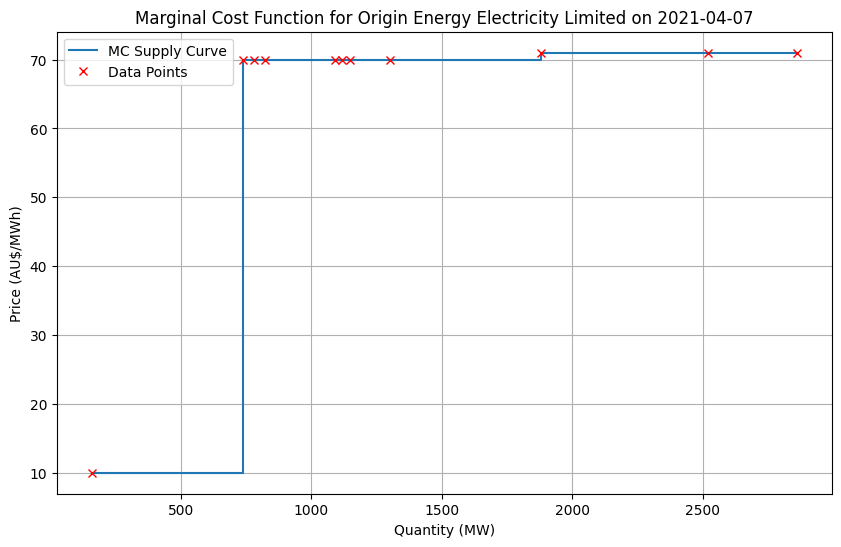

In [119]:
# Plot the Marginal Cost curve for firm i

# 3. Plot the stepwise MC (price) function
plt.figure(figsize=(10, 6))

# Plot the step function (supply curve)
plt.step(
    dispatch_df_time_date_company['CumulativeCapacity'],
    dispatch_df_time_date_company['AU$/MWh'],
    where='post',
    label="MC Supply Curve"
)

# 4. Overlay cross markers for each data point
plt.plot(
    dispatch_df_time_date_company['CumulativeCapacity'],
    dispatch_df_time_date_company['AU$/MWh'],
    linestyle="None",   # no line, only markers
    marker="x",         # cross markers
    color="red",
    label="Data Points"
)

# 5. Label the axes
plt.xlabel("Quantity (MW)")
plt.ylabel("Price (AU$/MWh)")
plt.title(f"Marginal Cost Function for {firm_i} on {date}")

# Add a legend and grid for clarity
plt.legend()
plt.grid(True)

plt.show()

# Find the Supply Bid Function

Preliminary:
Remove any rows which are not energy actions as these are bids for the separate balancing market.

As with filtering the dispatch_df, we will follow the hierarchial structure of time_date_company
Time is fixed and then a nested loop is needed to go through the different dates and companies.

In [15]:
# We now need to find the supply bids to work out residual demand and the actual supply bid function
volume_bids = dynamic_data_compiler(start_time='2021/03/01 00:00:00',
                                   end_time='2021/04/10 00:00:00',
                                   table_name='BIDPEROFFER_D',
                                   raw_data_location=raw_data_cache)

INFO: Compiling data for table BIDPEROFFER_D
INFO: Downloading data for table BIDPEROFFER_D, year 2021, month 03
INFO: Returning BIDPEROFFER_D.


In [17]:
# Join the dispatch_units and the dispatch_load tables on DUID

# Perform an outer join to ensure we keep all DUIDs and settlement dates
merged_bids_with_units_df = pd.merge(volume_bids, generator_info_df, on="DUID", how="outer")

In [18]:
filtered_merged_bids_with_units_df  = merged_bids_with_units_df[merged_bids_with_units_df['BIDTYPE'] == 'ENERGY']
filtered_merged_bids_with_units_df.shape

(868320, 31)

In [19]:
# Filter for only the 6-6:05pm auctions
# Here we look at the interval at 6pm because this is the start of the auction where the bids apply
bids_time_df = filtered_merged_bids_with_units_df[
    filtered_merged_bids_with_units_df["INTERVAL_DATETIME"].astype(str).str.contains("18:00:00", na=False)
]

In [61]:
# Filter for the single day we're looking at '2021-04-07'
# Eventually need to wrap this in a loop across all days

target_date = pd.to_datetime(date)
volume_bids_time_date_df = bids_time_df[bids_time_df['SETTLEMENTDATE'].dt.date == target_date.date()]

In [21]:
volume_bids_time_date_df

,SETTLEMENTDATE,DUID,BIDTYPE,OFFERDATE,MAXAVAIL,ENABLEMENTMIN,ENABLEMENTMAX,LOWBREAKPOINT,HIGHBREAKPOINT,BANDAVAIL1,BANDAVAIL2,BANDAVAIL3,BANDAVAIL4,BANDAVAIL5,BANDAVAIL6,BANDAVAIL7,BANDAVAIL8,BANDAVAIL9,BANDAVAIL10,INTERVAL_DATETIME,Participant,Station Name,Region,Dispatch Type,Category,Classification,Fuel Source - Primary,Fuel Source - Descriptor,Technology Type - Primary,Technology Type - Descriptor,Aggregation
1951,2021-04-07,AGLHAL,ENERGY,2021-04-07 17:42:19,156.0,NaN,NaN,NaN,NaN,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,225.0,2021-04-07 18:00:00,EnergyAustralia Yallourn Pty Ltd,Hallett Power Station,SA1,Generating Unit,Market,Scheduled,Fossil,Natural Gas / Diesel,Combustion,Open Cycle Gas turbines (OCGT),Y
4543,2021-04-07,AGLSOM,ENERGY,2021-04-06 09:58:41,160.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,170.0,2021-04-07 18:00:00,AGL Hydro Partnership,Somerton Power Station,VIC1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y
7135,2021-04-07,ANGAST1,ENERGY,2021-04-07 16:14:38,49.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,37.0,0.0,0.0,0.0,50.0,2021-04-07 18:00:00,Snowy Hydro Limited,Angaston Power Station,SA1,Generating Unit,Market,Scheduled,Fossil,Diesel,Combustion,Compression Reciprocating Engine,Y
17504,2021-04-07,ARWF1,ENERGY,2021-03-30 12:19:05,241.0,NaN,NaN,NaN,NaN,0.0,241.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-04-07 18:00:00,Ararat Wind Farm Pty Ltd,Ararat Wind Farm,VIC1,Generating Unit,Market,Semi-Scheduled,Wind,Wind,Renewable,Wind - Onshore,Y
86838,2021-04-07,BALBG1,ENERGY,2021-03-26 13:32:22,30.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,10.0,10.0,10.0,0.0,0.0,0.0,2021-04-07 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2923219,2021-04-07,YENDWF1,ENERGY,2021-04-06 08:59:13,142.0,NaN,NaN,NaN,NaN,0.0,142.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-04-07 18:00:00,Lal Lal Wind Farms Nom Co Pty Ltd,Yendon Wind Farm,VIC1,Generating Unit,Market,Semi-Scheduled,Wind,Wind,Renewable,Wind - Onshore,Y
2941357,2021-04-07,YWPS1,ENERGY,2021-04-03 22:01:20,0.0,NaN,NaN,NaN,NaN,300.0,0.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,2021-04-07 18:00:00,EnergyAustralia Yallourn Pty Ltd,Yallourn 'W' Power Station,VIC1,Generating Unit,Market,Scheduled,Fossil,Brown Coal,Combustion,Steam Sub-Critical,Y
2964685,2021-04-07,YWPS2,ENERGY,2021-04-04 17:42:54,0.0,NaN,NaN,NaN,NaN,380.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,2021-04-07 18:00:00,EnergyAustralia Yallourn Pty Ltd,Yallourn 'W' Power Station,VIC1,Generating Unit,Market,Scheduled,Fossil,Brown Coal,Combustion,Steam Sub-Critical,Y
2988013,2021-04-07,YWPS3,ENERGY,2021-04-07 15:59:08,390.0,NaN,NaN,NaN,NaN,396.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,2021-04-07 18:00:00,EnergyAustralia Yallourn Pty Ltd,Yallourn 'W' Power Station,VIC1,Generating Unit,Market,Scheduled,Fossil,Brown Coal,Combustion,Steam Sub-Critical,Y


In [22]:
volume_bids_time_date_df.shape

(335, 31)

In [24]:
# This is the number of DUIDS
# We need to first aggregate into the same market participants (firms)
# And then find the residual demand from each residual bid
unique_DUIDs = volume_bids_time_date_df["DUID"].unique()
len(unique_DUIDs)

335

In [25]:
unique_participants = volume_bids_time_date_df["Participant"].unique()
len(unique_participants)

115

In [26]:
# # Filter for 'Origin Energy Electricity Limited'
# filtered_bids_df = bids_with_duid[bids_with_duid["Participant"] == "Origin Energy Electricity Limited"]

What is the strategy for price bids?
Important to recall that price bids only change once a day
We need to match the price bands ups with volume bids based on the DUID
Can I just do this in one go per day?

Filtering:
Remove any bids that are not 'ENERGY'

In [27]:
# Get the price bids.
price_bids_df = dynamic_data_compiler(start_time='2021/03/01 00:00:00',
                                   end_time='2021/04/10 00:00:00',
                                   table_name='BIDDAYOFFER_D',
                                   raw_data_location=raw_data_cache)

INFO: Compiling data for table BIDDAYOFFER_D
INFO: Downloading data for table BIDDAYOFFER_D, year 2021, month 03
INFO: Returning BIDDAYOFFER_D.


In [28]:
price_bids_filtered_df = price_bids_df[price_bids_df['BIDTYPE'] == 'ENERGY']

In [29]:
price_bids_day_df = price_bids_filtered_df[price_bids_filtered_df['SETTLEMENTDATE'] == '2021-04-07']
price_bids_day_df

,SETTLEMENTDATE,DUID,BIDTYPE,OFFERDATE,VERSIONNO,PRICEBAND1,PRICEBAND2,PRICEBAND3,PRICEBAND4,PRICEBAND5,PRICEBAND6,PRICEBAND7,PRICEBAND8,PRICEBAND9,PRICEBAND10,MINIMUMLOAD,T1,T2,T3,T4
0,2021-04-07,ARWF1,ENERGY,2021-03-30 12:19:05,1,-898.30,-157.00,2.00,4.00,8.00,16.00,32.00,64.00,128.00,13025.35,0.0,0.0,0.0,0.0,0.0
8,2021-04-07,BALBL1,ENERGY,2021-03-26 13:40:09,1,-47.08,-23.01,0.00,9.52,49.97,70.19,91.38,114.49,291.68,924.37,0.0,0.0,0.0,0.0,0.0
10,2021-04-07,BARCALDN,ENERGY,2021-02-25 17:21:07,1,-796.01,-12.12,0.00,14.54,24.23,40.39,52.50,242.31,403.85,11940.08,12.0,14.0,4.0,1.0,4.0
11,2021-04-07,BBTHREE2,ENERGY,2021-04-06 10:00:47,1,-997.08,-69.23,-0.58,11.39,25.36,26.23,50.29,138.38,449.29,13220.58,17.0,5.0,5.0,1.0,1.0
12,2021-04-07,BERYLSF1,ENERGY,2021-04-02 08:55:34,1,-934.80,-30.00,0.00,1.00,2.00,8.00,16.00,32.00,128.00,12999.00,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,2021-04-07,TORRA1,ENERGY,2021-04-06 09:58:30,1,-999.80,0.00,41.99,62.99,85.98,147.97,299.94,448.91,11446.71,14997.00,0.0,0.0,0.0,0.0,0.0
1135,2021-04-07,TORRB4,ENERGY,2021-04-06 09:58:30,1,-999.80,0.00,41.99,61.99,117.98,247.95,348.93,10996.80,12996.40,14997.00,0.0,0.0,0.0,0.0,0.0
1142,2021-04-07,VP5,ENERGY,2021-04-06 22:11:11,1,-985.70,-3.75,32.53,35.04,38.56,49.19,64.07,108.43,295.71,14083.68,0.0,0.0,0.0,0.0,0.0
1151,2021-04-07,WARWSF2,ENERGY,2021-03-27 08:35:36,1,-972.29,-291.69,-48.61,0.00,48.61,194.46,291.69,388.92,4861.47,14584.41,0.0,0.0,0.0,0.0,0.0


In [31]:
merged_volume_and_price_bids_df = pd.merge(price_bids_day_df, volume_bids_time_date_df, on=["DUID", "SETTLEMENTDATE"])
merged_volume_and_price_bids_df

,SETTLEMENTDATE,DUID,BIDTYPE_x,OFFERDATE_x,VERSIONNO,PRICEBAND1,PRICEBAND2,PRICEBAND3,PRICEBAND4,PRICEBAND5,PRICEBAND6,PRICEBAND7,PRICEBAND8,PRICEBAND9,PRICEBAND10,MINIMUMLOAD,T1,T2,T3,T4,BIDTYPE_y,OFFERDATE_y,MAXAVAIL,ENABLEMENTMIN,ENABLEMENTMAX,LOWBREAKPOINT,HIGHBREAKPOINT,BANDAVAIL1,BANDAVAIL2,BANDAVAIL3,BANDAVAIL4,BANDAVAIL5,BANDAVAIL6,BANDAVAIL7,BANDAVAIL8,BANDAVAIL9,BANDAVAIL10,INTERVAL_DATETIME,Participant,Station Name,Region,Dispatch Type,Category,Classification,Fuel Source - Primary,Fuel Source - Descriptor,Technology Type - Primary,Technology Type - Descriptor,Aggregation
0,2021-04-07,ARWF1,ENERGY,2021-03-30 12:19:05,1,-898.30,-157.00,2.00,4.00,8.00,16.00,32.00,64.00,128.00,13025.35,0.0,0.0,0.0,0.0,0.0,ENERGY,2021-03-30 12:19:05,241.0,NaN,NaN,NaN,NaN,0.0,241.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-04-07 18:00:00,Ararat Wind Farm Pty Ltd,Ararat Wind Farm,VIC1,Generating Unit,Market,Semi-Scheduled,Wind,Wind,Renewable,Wind - Onshore,Y
1,2021-04-07,BALBL1,ENERGY,2021-03-26 13:40:09,1,-47.08,-23.01,0.00,9.52,49.97,70.19,91.38,114.49,291.68,924.37,0.0,0.0,0.0,0.0,0.0,ENERGY,2021-04-07 16:05:19,0.0,NaN,NaN,NaN,NaN,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-04-07 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-04-07,BARCALDN,ENERGY,2021-02-25 17:21:07,1,-796.01,-12.12,0.00,14.54,24.23,40.39,52.50,242.31,403.85,11940.08,12.0,14.0,4.0,1.0,4.0,ENERGY,2021-02-25 17:21:07,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.0,2021-04-07 18:00:00,Ergon Energy Queensland Pty Ltd,Barcaldine Power Station,QLD1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Combined Cycle Gas Turbine (CCGT),Y
3,2021-04-07,BBTHREE2,ENERGY,2021-04-06 10:00:47,1,-997.08,-69.23,-0.58,11.39,25.36,26.23,50.29,138.38,449.29,13220.58,17.0,5.0,5.0,1.0,1.0,ENERGY,2021-04-06 10:00:47,40.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,9.0,2021-04-07 18:00:00,Hydro-Electric Corporation,Bell Bay Three Power Station,TAS1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y
4,2021-04-07,BERYLSF1,ENERGY,2021-04-02 08:55:34,1,-934.80,-30.00,0.00,1.00,2.00,8.00,16.00,32.00,128.00,12999.00,0.0,0.0,0.0,0.0,0.0,ENERGY,2021-04-02 08:55:34,87.0,NaN,NaN,NaN,NaN,87.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-04-07 18:00:00,FS NSW Project No 1 At Pty Ltd ATF The FS NSW ...,Beryl Solar Farm,NSW1,Generating Unit,Market,Semi-Scheduled,Solar,Solar,Renewable,Photovoltaic Tracking Flat panel,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,2021-04-07,TORRA1,ENERGY,2021-04-06 09:58:30,1,-999.80,0.00,41.99,62.99,85.98,147.97,299.94,448.91,11446.71,14997.00,0.0,0.0,0.0,0.0,0.0,ENERGY,2021-04-06 09:58:30,0.0,NaN,NaN,NaN,NaN,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0,2021-04-07 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
331,2021-04-07,TORRB4,ENERGY,2021-04-06 09:58:30,1,-999.80,0.00,41.99,61.99,117.98,247.95,348.93,10996.80,12996.40,14997.00,0.0,0.0,0.0,0.0,0.0,ENERGY,2021-04-06 09:58:30,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,210.0,2021-04-07 18:00:00,AGL SA Generation Pty Limited,Torrens Island Power Station,SA1,Generating Unit,Market,Scheduled,Fossil,Natural Gas / Fuel Oil,Combustion,Steam Sub-Critical,Y
332,2021-04-07,VP5,ENERGY,2021-04-06 22:11:11,1,-985.70,-3.75,32.53,35.04,38.56,49.19,64.07,108.43,295.71,14083.68,0.0,0.0,0.0,0.0,0.0,ENERGY,2021-04-07 15:01:44,610.0,NaN,NaN,NaN,NaN,250.0,0.0,100.0,100.0,100.0,50.0,0.0,30.0,0.0,50.0,2021-04-07 18:00:00,Delta Electricity,"Vales Point ""B"" Power Station",NSW1,Generating Unit,Market,Scheduled,Fossil,Black Coal,Combustion,Steam Sub-Critical,Y
333,2021-04-07,WARWSF2,ENERGY,2021-03-27 08:35:36,1,-972.29,-291.69,-48.61,0.00,48.61,194.46,291.69,388.92,4861.47,14584.41,0.0,0.0,0.0,0.0,0.0,ENERGY,2021-03-27 08:35:36,16.0,NaN,NaN,NaN,NaN,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,202

In [32]:
# Remove where max avail is zero because these are placeholder bids
# Where the generator is not able to produce
merged_volume_and_price_bids_filtered_df = merged_volume_and_price_bids_df[merged_volume_and_price_bids_df["MAXAVAIL"] != 0]
merged_volume_and_price_bids_filtered_df

,SETTLEMENTDATE,DUID,BIDTYPE_x,OFFERDATE_x,VERSIONNO,PRICEBAND1,PRICEBAND2,PRICEBAND3,PRICEBAND4,PRICEBAND5,PRICEBAND6,PRICEBAND7,PRICEBAND8,PRICEBAND9,PRICEBAND10,MINIMUMLOAD,T1,T2,T3,T4,BIDTYPE_y,OFFERDATE_y,MAXAVAIL,ENABLEMENTMIN,ENABLEMENTMAX,LOWBREAKPOINT,HIGHBREAKPOINT,BANDAVAIL1,BANDAVAIL2,BANDAVAIL3,BANDAVAIL4,BANDAVAIL5,BANDAVAIL6,BANDAVAIL7,BANDAVAIL8,BANDAVAIL9,BANDAVAIL10,INTERVAL_DATETIME,Participant,Station Name,Region,Dispatch Type,Category,Classification,Fuel Source - Primary,Fuel Source - Descriptor,Technology Type - Primary,Technology Type - Descriptor,Aggregation
0,2021-04-07,ARWF1,ENERGY,2021-03-30 12:19:05,1,-898.30,-157.00,2.00,4.00,8.00,16.00,32.00,64.00,128.00,13025.35,0.0,0.0,0.0,0.0,0.0,ENERGY,2021-03-30 12:19:05,241.0,NaN,NaN,NaN,NaN,0.0,241.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-04-07 18:00:00,Ararat Wind Farm Pty Ltd,Ararat Wind Farm,VIC1,Generating Unit,Market,Semi-Scheduled,Wind,Wind,Renewable,Wind - Onshore,Y
3,2021-04-07,BBTHREE2,ENERGY,2021-04-06 10:00:47,1,-997.08,-69.23,-0.58,11.39,25.36,26.23,50.29,138.38,449.29,13220.58,17.0,5.0,5.0,1.0,1.0,ENERGY,2021-04-06 10:00:47,40.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,9.0,2021-04-07 18:00:00,Hydro-Electric Corporation,Bell Bay Three Power Station,TAS1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y
4,2021-04-07,BERYLSF1,ENERGY,2021-04-02 08:55:34,1,-934.80,-30.00,0.00,1.00,2.00,8.00,16.00,32.00,128.00,12999.00,0.0,0.0,0.0,0.0,0.0,ENERGY,2021-04-02 08:55:34,87.0,NaN,NaN,NaN,NaN,87.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-04-07 18:00:00,FS NSW Project No 1 At Pty Ltd ATF The FS NSW ...,Beryl Solar Farm,NSW1,Generating Unit,Market,Semi-Scheduled,Solar,Solar,Renewable,Photovoltaic Tracking Flat panel,Y
5,2021-04-07,BLUFF1,ENERGY,2021-04-06 09:58:30,1,-966.10,-869.49,-143.95,-49.13,-33.81,-0.97,289.83,966.10,9661.00,14491.50,0.0,0.0,0.0,0.0,0.0,ENERGY,2021-04-07 15:30:15,52.0,NaN,NaN,NaN,NaN,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-04-07 18:00:00,AGL SA Generation Pty Limited,The Bluff Wind Farm,SA1,Generating Unit,Market,Semi-Scheduled,Wind,Wind,Renewable,Wind - Onshore,N
6,2021-04-07,BODWF1,ENERGY,2021-04-06 07:35:29,1,-965.90,-964.93,-110.11,-77.27,-57.95,-1.93,286.87,4816.94,12370.42,14198.73,0.0,0.0,0.0,0.0,0.0,ENERGY,2021-04-06 07:35:29,111.0,NaN,NaN,NaN,NaN,111.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-04-07 18:00:00,Bodangora Wind Farm Pty Limited,Bodangora Wind Farm,NSW1,Generating Unit,Market,Semi-Scheduled,Wind,Wind,Renewable,Wind - Onshore,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327,2021-04-07,SALTCRK1,ENERGY,2021-03-24 12:00:15,1,-958.80,-383.52,-300.11,-206.15,-69.34,-22.54,21.91,122.73,4314.61,14382.00,0.0,0.0,0.0,0.0,0.0,ENERGY,2021-03-24 12:00:15,54.0,NaN,NaN,NaN,NaN,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-04-07 18:00:00,Salt Creek Wind Farm Pty Ltd,Salt Creek Wind Farm,VIC1,Generating Unit,Market,Semi-Scheduled,Wind,Wind,Renewable,Wind - Onshore,Y
329,2021-04-07,TNPS1,ENERGY,2021-04-06 16:02:59,1,-972.00,-72.05,0.00,9.75,14.62,31.35,341.08,3386.01,14576.11,14580.00,0.0,0.0,0.0,0.0,0.0,ENERGY,2021-04-07 17:07:17,443.0,NaN,NaN,NaN,NaN,443.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.0,2021-04-07 18:00:00,Stanwell Corporation Limited,Tarong North Power Station,QLD1,Generating Unit,Market,Scheduled,Fossil,Black Coal,Combustion,Steam Super Critical,Y
332,2021-04-07,VP5,ENERGY,2021-04-06 22:11:11,1,-985.70,-3.75,32.53,35.04,38.56,49.19,64.07,108.43,295.71,14083.68,0.0,0.0,0.0,0.0,0.0,ENERGY,2021-04-07 15:01:44,610.0,NaN,NaN,NaN,NaN,250.0,0.0,100.0,100.0,100.0,50.0,0.0,30.0,0.0,50.0,2021-04-07 18:00:00,Delta Electricity,"Vales Point ""B"" Power Station",NSW1,Generating Unit,Market,Scheduled,Fossil,Black Coal,Combustion,Steam Sub-Critical,Y
333,2021-04-07,WARWSF2,ENERGY,2021-03-27 08:35:36,1,-972.29,-291.69,-48.61,0.

In [33]:
# What is the maximum Megawatts that are able to be produced in this auction
# if all generators generated at peak capacity
max_avail = merged_volume_and_price_bids_filtered_df['MAXAVAIL'].sum()
max_avail

43819.0

There is a modification required because the total capacity that firms bid is often higher than the max capacity of the generator. This is because the max capacity takes priority and the auctioneer caps firms at their submitted max capacity. This means firms are able to bid whatever volumes in the knowledge they won't be called to produce more than their actual max capacity. 

We will have the columns:
MAXAVAIL: Hard limit
TOTAL_BANDAVAIL: Total volume bid
SUM_OF_BANDAVAIL: The capped volume bid so that what firms bid matches the hard limit 

In [44]:
# 1. Identify the band availability columns
bandavail_cols = [f"BANDAVAIL{i}" for i in range(1, 11)]  # BANDAVAIL1 to BANDAVAIL10

# 2. Create a new column summing them correctly with .loc to avoid SettingWithCopyWarning
merged_volume_and_price_bids_filtered_df = merged_volume_and_price_bids_filtered_df.copy()  # Ensure we are working on a copy
merged_volume_and_price_bids_filtered_df.loc[:, "TOTAL_BANDAVAIL"] = merged_volume_and_price_bids_filtered_df[bandavail_cols].sum(axis=1)

# 3. Remove rows where TOTAL_BANDAVAIL is 0
no_zeroes_combined_bids_df = merged_volume_and_price_bids_filtered_df[merged_volume_and_price_bids_filtered_df["TOTAL_BANDAVAIL"] != 0].copy()

In [45]:
"""
For each row in the group (same DUID & SETTLEMENTDATE):
  1) Sort the 10 band pairs by ascending price.
  2) Accumulate volumes, stopping at MAXAVAIL.
  3) Partially fill the band where we hit the limit.
  4) Set subsequent bands to zero.
  5) Write the modified band volumes back in the original wide order.
"""
    
def cap_bands_in_wide_mode(group):

    # We'll modify each row separately
    new_rows = []
    
    for _, row in group.iterrows():
        
        # Extract max_avail for this row
        max_avail = row["MAXAVAIL"]
        
        # Gather the 10 band pairs: (price, volume, band_index)
        # E.g., (PRICEBAND1, BANDAVAIL1, index=1), etc.
        band_info = []
        for i in range(1, 11):
            price_col = f"PRICEBAND{i}"
            vol_col   = f"BANDAVAIL{i}"
            
            price_val = row[price_col]
            vol_val   = row[vol_col]
            
            band_info.append((price_val, vol_val, i))
        
        # Sort by ascending price
        band_info.sort(key=lambda x: x[0] if not pd.isna(x[0]) else np.inf)
        
        # Accumulate volumes, capping at max_avail
        running_sum = 0.0
        capped_bands = []
        
        for (price, volume, idx) in band_info:
            if pd.isna(volume): 
                # If volume is NaN, treat it as 0
                volume = 0.0
            
            if running_sum >= max_avail:
                # Already at or beyond limit
                capped_bands.append((price, 0.0, idx))
            else:
                potential = running_sum + volume
                if potential <= max_avail:
                    # Can use full band
                    capped_bands.append((price, volume, idx))
                    running_sum += volume
                else:
                    # Partially use this band
                    remainder = max_avail - running_sum
                    capped_bands.append((price, remainder, idx))
                    running_sum += remainder
        
        # Now re-sort by the original band index so we can put them back into the row
        capped_bands.sort(key=lambda x: x[2])
        
        # Write them back into the row's band columns
        row_capped = row.copy()  # copy original
        for (price, cap_vol, idx) in capped_bands:
            vol_col = f"BANDAVAIL{idx}"
            row_capped[vol_col] = cap_vol
        
        new_rows.append(row_capped)
    
    # Return the modified rows as a DataFrame
    return pd.DataFrame(new_rows)

capped_combined_bids_df = (
    no_zeroes_combined_bids_df
    .groupby(["DUID", "SETTLEMENTDATE"], group_keys=False)
    .apply(cap_bands_in_wide_mode)
)

capped_combined_bids_df

/var/folders/xw/3fpv2dn948lcf41k_wd6vbxh0000gn/T/ipykernel_4457/1567338815.py:76: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(cap_bands_in_wide_mode)


,SETTLEMENTDATE,DUID,BIDTYPE_x,OFFERDATE_x,VERSIONNO,PRICEBAND1,PRICEBAND2,PRICEBAND3,PRICEBAND4,PRICEBAND5,PRICEBAND6,PRICEBAND7,PRICEBAND8,PRICEBAND9,PRICEBAND10,MINIMUMLOAD,T1,T2,T3,T4,BIDTYPE_y,OFFERDATE_y,MAXAVAIL,ENABLEMENTMIN,ENABLEMENTMAX,LOWBREAKPOINT,HIGHBREAKPOINT,BANDAVAIL1,BANDAVAIL2,BANDAVAIL3,BANDAVAIL4,BANDAVAIL5,BANDAVAIL6,BANDAVAIL7,BANDAVAIL8,BANDAVAIL9,BANDAVAIL10,INTERVAL_DATETIME,Participant,Station Name,Region,Dispatch Type,Category,Classification,Fuel Source - Primary,Fuel Source - Descriptor,Technology Type - Primary,Technology Type - Descriptor,Aggregation,TOTAL_BANDAVAIL
0,2021-04-07,ARWF1,ENERGY,2021-03-30 12:19:05,1,-898.30,-157.00,2.00,4.00,8.00,16.00,32.00,64.00,128.00,13025.35,0.0,0.0,0.0,0.0,0.0,ENERGY,2021-03-30 12:19:05,241.0,NaN,NaN,NaN,NaN,0.0,241.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-04-07 18:00:00,Ararat Wind Farm Pty Ltd,Ararat Wind Farm,VIC1,Generating Unit,Market,Semi-Scheduled,Wind,Wind,Renewable,Wind - Onshore,Y,241.0
3,2021-04-07,BBTHREE2,ENERGY,2021-04-06 10:00:47,1,-997.08,-69.23,-0.58,11.39,25.36,26.23,50.29,138.38,449.29,13220.58,17.0,5.0,5.0,1.0,1.0,ENERGY,2021-04-06 10:00:47,40.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,2021-04-07 18:00:00,Hydro-Electric Corporation,Bell Bay Three Power Station,TAS1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,49.0
4,2021-04-07,BERYLSF1,ENERGY,2021-04-02 08:55:34,1,-934.80,-30.00,0.00,1.00,2.00,8.00,16.00,32.00,128.00,12999.00,0.0,0.0,0.0,0.0,0.0,ENERGY,2021-04-02 08:55:34,87.0,NaN,NaN,NaN,NaN,87.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-04-07 18:00:00,FS NSW Project No 1 At Pty Ltd ATF The FS NSW ...,Beryl Solar Farm,NSW1,Generating Unit,Market,Semi-Scheduled,Solar,Solar,Renewable,Photovoltaic Tracking Flat panel,Y,87.0
5,2021-04-07,BLUFF1,ENERGY,2021-04-06 09:58:30,1,-966.10,-869.49,-143.95,-49.13,-33.81,-0.97,289.83,966.10,9661.00,14491.50,0.0,0.0,0.0,0.0,0.0,ENERGY,2021-04-07 15:30:15,52.0,NaN,NaN,NaN,NaN,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-04-07 18:00:00,AGL SA Generation Pty Limited,The Bluff Wind Farm,SA1,Generating Unit,Market,Semi-Scheduled,Wind,Wind,Renewable,Wind - Onshore,N,53.0
6,2021-04-07,BODWF1,ENERGY,2021-04-06 07:35:29,1,-965.90,-964.93,-110.11,-77.27,-57.95,-1.93,286.87,4816.94,12370.42,14198.73,0.0,0.0,0.0,0.0,0.0,ENERGY,2021-04-06 07:35:29,111.0,NaN,NaN,NaN,NaN,111.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-04-07 18:00:00,Bodangora Wind Farm Pty Limited,Bodangora Wind Farm,NSW1,Generating Unit,Market,Semi-Scheduled,Wind,Wind,Renewable,Wind - Onshore,Y,111.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327,2021-04-07,SALTCRK1,ENERGY,2021-03-24 12:00:15,1,-958.80,-383.52,-300.11,-206.15,-69.34,-22.54,21.91,122.73,4314.61,14382.00,0.0,0.0,0.0,0.0,0.0,ENERGY,2021-03-24 12:00:15,54.0,NaN,NaN,NaN,NaN,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-04-07 18:00:00,Salt Creek Wind Farm Pty Ltd,Salt Creek Wind Farm,VIC1,Generating Unit,Market,Semi-Scheduled,Wind,Wind,Renewable,Wind - Onshore,Y,54.0
329,2021-04-07,TNPS1,ENERGY,2021-04-06 16:02:59,1,-972.00,-72.05,0.00,9.75,14.62,31.35,341.08,3386.01,14576.11,14580.00,0.0,0.0,0.0,0.0,0.0,ENERGY,2021-04-07 17:07:17,443.0,NaN,NaN,NaN,NaN,443.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-04-07 18:00:00,Stanwell Corporation Limited,Tarong North Power Station,QLD1,Generating Unit,Market,Scheduled,Fossil,Black Coal,Combustion,Steam Super Critical,Y,480.0
332,2021-04-07,VP5,ENERGY,2021-04-06 22:11:11,1,-985.70,-3.75,32.53,35.04,38.56,49.19,64.07,108.43,295.71,14083.68,0.0,0.0,0.0,0.0,0.0,ENERGY,2021-04-07 15:01:44,610.0,NaN,NaN,NaN,NaN,250.0,0.0,100.0,100.0,100.0,50.0,0.0,10.0,0.0,0.0,2021-04-07 18:00:00,Delta Electricity,"Vales Point ""B"" Power Station",NSW1,Generating Unit,Market,Scheduled,Fossil,Black Coal,Combustion,Steam Sub-Critical,Y,680.0
333,2021-04-07,

In [36]:
# Define columns for melting
price_columns = [f"PRICEBAND{i}" for i in range(1, 11)]
volume_columns = [f"BANDAVAIL{i}" for i in range(1, 11)]

# Include the additional columns you want to keep in long format
id_vars_cols = [
    "DUID",
    "SETTLEMENTDATE",
    "Participant",
    "Station Name",
    "Fuel Source - Descriptor"
]

# Melt price bands into long format
melted_prices = (
    capped_combined_bids_df
    .melt(
        id_vars=id_vars_cols,             # <--- Add your additional columns here
        value_vars=price_columns,
        var_name="PRICE_BAND",
        value_name="PRICE"
    )
)

# Melt volume bands into long format
melted_volumes = (
    capped_combined_bids_df
    .melt(
        id_vars=id_vars_cols,             # <--- Same additional columns
        value_vars=volume_columns,
        var_name="VOLUME_BAND",
        value_name="VOLUME"
    )
)

# Extract the band number (1..10) from PRICE_BAND or VOLUME_BAND
melted_prices["BAND_NUMBER"] = melted_prices["PRICE_BAND"].str.extract(r"(\d+)").astype(int)
melted_volumes["BAND_NUMBER"] = melted_volumes["VOLUME_BAND"].str.extract(r"(\d+)").astype(int)

# Merge long-format prices and volumes on DUID, SETTLEMENTDATE, and BAND_NUMBER
bid_curve_df = pd.merge(
    melted_prices,
    melted_volumes,
    on=["DUID", "SETTLEMENTDATE", "Participant", "Station Name", "Fuel Source - Descriptor", "BAND_NUMBER"]
)

# View the merged DataFrame
bid_curve_df.head()

,DUID,SETTLEMENTDATE,Participant,Station Name,Fuel Source - Descriptor,PRICE_BAND,PRICE,BAND_NUMBER,VOLUME_BAND,VOLUME
0,ARWF1,2021-04-07,Ararat Wind Farm Pty Ltd,Ararat Wind Farm,Wind,PRICEBAND1,-898.30,1,BANDAVAIL1,0.0
1,BBTHREE2,2021-04-07,Hydro-Electric Corporation,Bell Bay Three Power Station,Natural Gas,PRICEBAND1,-997.08,1,BANDAVAIL1,0.0
2,BERYLSF1,2021-04-07,FS NSW Project No 1 At Pty Ltd ATF The FS NSW ...,Beryl Solar Farm,Solar,PRICEBAND1,-934.80,1,BANDAVAIL1,87.0
3,BLUFF1,2021-04-07,AGL SA Generation Pty Limited,The Bluff Wind Farm,Wind,PRICEBAND1,-966.10,1,BANDAVAIL1,52.0
4,BODWF1,2021-04-07,Bodangora Wind Farm Pty Limited,Bodangora Wind Farm,Wind,PRICEBAND1,-965.90,1,BANDAVAIL1,111.0


In [38]:
bid_curve_df.shape

(2580, 10)

In [ ]:
bid_curve_df = bid_curve_df.sort_values(by=["DUID", "SETTLEMENTDATE", "PRICE"])
bid_curve_df["CUMULATIVE_VOLUME"] = bid_curve_df.groupby(["DUID", "SETTLEMENTDATE"])["VOLUME"].cumsum()
with pd.option_context('display.max_rows', None, 
                      'display.max_columns', None,
                      'display.width', None,
                      'display.max_colwidth', None):
    display(bid_curve_df)

,DUID,SETTLEMENTDATE,Participant,Station Name,Fuel Source - Descriptor,PRICE_BAND,PRICE,BAND_NUMBER,VOLUME_BAND,VOLUME,CUMULATIVE_VOLUME
97,AGLHAL,2021-04-07,EnergyAustralia Yallourn Pty Ltd,Hallett Power Station,Natural Gas / Diesel,PRICEBAND1,-966.60,1,BANDAVAIL1,30.0,30.0
355,AGLHAL,2021-04-07,EnergyAustralia Yallourn Pty Ltd,Hallett Power Station,Natural Gas / Diesel,PRICEBAND2,0.00,2,BANDAVAIL2,0.0,30.0
613,AGLHAL,2021-04-07,EnergyAustralia Yallourn Pty Ltd,Hallett Power Station,Natural Gas / Diesel,PRICEBAND3,269.50,3,BANDAVAIL3,0.0,30.0
871,AGLHAL,2021-04-07,EnergyAustralia Yallourn Pty Ltd,Hallett Power Station,Natural Gas / Diesel,PRICEBAND4,356.49,4,BANDAVAIL4,0.0,30.0
1129,AGLHAL,2021-04-07,EnergyAustralia Yallourn Pty Ltd,Hallett Power Station,Natural Gas / Diesel,PRICEBAND5,404.82,5,BANDAVAIL5,0.0,30.0
1387,AGLHAL,2021-04-07,EnergyAustralia Yallourn Pty Ltd,Hallett Power Station,Natural Gas / Diesel,PRICEBAND6,482.15,6,BANDAVAIL6,0.0,30.0
1645,AGLHAL,2021-04-07,EnergyAustralia Yallourn Pty Ltd,Hallett Power Station,Natural Gas / Diesel,PRICEBAND7,559.48,7,BANDAVAIL7,0.0,30.0
1903,AGLHAL,2021-04-07,EnergyAustralia Yallourn Pty Ltd,Hallett Power Station,Natural Gas / Diesel,PRICEBAND8,1319.95,8,BANDAVAIL8,0.0,30.0
2161,AGLHAL,2021-04-07,EnergyAustralia Yallourn Pty Ltd,Hallett Power Station,Natural Gas / Diesel,PRICEBAND9,12565.80,9,BANDAVAIL9,0.0,30.0
2419,AGLHAL,2021-04-07,EnergyAustralia Yallourn Pty Ltd,Hallett Power Station,Natural Gas / Diesel,PRICEBAND10,14499.00,10,BANDAVAIL10,126.0,156.0


In [50]:
# This aggregates volumes by (Participant, SETTLEMENTDATE, PRICE)
# meaning that we can construct a firm-wide aggregate supply function 
# which has multiple DUIDs

firm_aggregated_bids = (
    bid_curve_df
    .groupby(["Participant", "SETTLEMENTDATE", "PRICE"], as_index=False)["VOLUME"]
    .sum()
)

# 2) Sort so we can build a piecewise curve in ascending PRICE order
firm_aggregated_bids = firm_aggregated_bids.sort_values(["Participant", "SETTLEMENTDATE", "PRICE"])

firm_aggregated_bids["FIRM_CUMULATIVE_VOLUME"] = (
    aggregated_bids
    .groupby(["Participant", "SETTLEMENTDATE"])["VOLUME"]
    .cumsum()
)

In [53]:
firm_aggregated_bids["TOTAL_CUMULATIVE_VOLUME"] = firm_aggregated_bids.groupby("SETTLEMENTDATE")["VOLUME"].cumsum()

In [54]:
firm_aggregated_bids

,Participant,SETTLEMENTDATE,PRICE,VOLUME,FIRM_CUMULATIVE_VOLUME,TOTAL_CUMULATIVE_VOLUME
0,AGL Hydro Partnership,2021-04-07,-1002.40,0.0,0.0,0.0
1,AGL Hydro Partnership,2021-04-07,-990.30,0.0,0.0,0.0
2,AGL Hydro Partnership,2021-04-07,-985.40,0.0,0.0,0.0
3,AGL Hydro Partnership,2021-04-07,-984.16,0.0,0.0,0.0
4,AGL Hydro Partnership,2021-04-07,-975.70,408.0,408.0,408.0
...,...,...,...,...,...,...
1913,Yatpool Sun Farm Pty Ltd,2021-04-07,78.99,0.0,81.0,42300.0
1914,Yatpool Sun Farm Pty Ltd,2021-04-07,197.46,0.0,81.0,42300.0
1915,Yatpool Sun Farm Pty Ltd,2021-04-07,473.92,0.0,81.0,42300.0
1916,Yatpool Sun Farm Pty Ltd,2021-04-07,2369.58,0.0,81.0,42300.0


## Finding the residual demand

In [59]:
firm_i_df = firm_aggregated_bids[firm_aggregated_bids["Participant"] == firm_i]
firm_i_df

,Participant,SETTLEMENTDATE,PRICE,VOLUME,FIRM_CUMULATIVE_VOLUME,TOTAL_CUMULATIVE_VOLUME
1199,Origin Energy Electricity Limited,2021-04-07,-985.4,27.0,27.0,25680.0
1200,Origin Energy Electricity Limited,2021-04-07,-984.5,615.0,642.0,26295.0
1201,Origin Energy Electricity Limited,2021-04-07,-983.5,280.0,922.0,26575.0
1202,Origin Energy Electricity Limited,2021-04-07,-980.9,120.0,1042.0,26695.0
1203,Origin Energy Electricity Limited,2021-04-07,-968.5,81.0,1123.0,26776.0
...,...,...,...,...,...,...
1293,Origin Energy Electricity Limited,2021-04-07,14527.5,0.0,3694.0,29347.0
1294,Origin Energy Electricity Limited,2021-04-07,14713.5,40.0,3734.0,29387.0
1295,Origin Energy Electricity Limited,2021-04-07,14752.5,0.0,3734.0,29387.0
1296,Origin Energy Electricity Limited,2021-04-07,14767.5,268.0,4002.0,29655.0


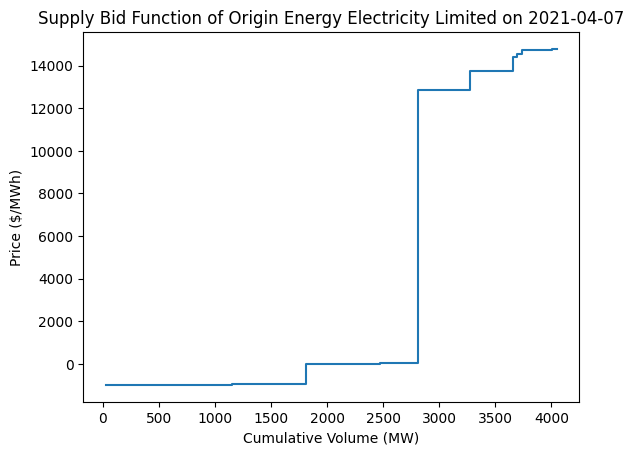

In [64]:
# Plot firm i's supply bid function

plt.step(firm_i_df["FIRM_CUMULATIVE_VOLUME"], firm_i_df["PRICE"], where='post')
plt.xlabel("Cumulative Volume (MW)")
plt.ylabel("Price ($/MWh)")
plt.title(f"Supply Bid Function of {firm_i} on {date}")
plt.show()

In [66]:
rival_firms_df = aggregated_bids[aggregated_bids["Participant"] != firm_i].copy()

In [67]:
rival_firms_df

,Participant,SETTLEMENTDATE,PRICE,VOLUME,FIRM_CUMULATIVE_VOLUME,TOTAL_CUMULATIVE_VOLUME
0,AGL Hydro Partnership,2021-04-07,-1002.40,0.0,0.0,0.0
1,AGL Hydro Partnership,2021-04-07,-990.30,0.0,0.0,0.0
2,AGL Hydro Partnership,2021-04-07,-985.40,0.0,0.0,0.0
3,AGL Hydro Partnership,2021-04-07,-984.16,0.0,0.0,0.0
4,AGL Hydro Partnership,2021-04-07,-975.70,408.0,408.0,408.0
...,...,...,...,...,...,...
1913,Yatpool Sun Farm Pty Ltd,2021-04-07,78.99,0.0,81.0,42300.0
1914,Yatpool Sun Farm Pty Ltd,2021-04-07,197.46,0.0,81.0,42300.0
1915,Yatpool Sun Farm Pty Ltd,2021-04-07,473.92,0.0,81.0,42300.0
1916,Yatpool Sun Farm Pty Ltd,2021-04-07,2369.58,0.0,81.0,42300.0


In [70]:
rival_grouped_df = (
    rival_firms_df
    .groupby(["SETTLEMENTDATE", "PRICE"], as_index=False)["VOLUME"]
    .sum()
    .rename(columns={"VOLUME": "RIVAL_VOLUME"})  # rename for clarity
)

# Compute stepwise cumulative supply for each date
rival_grouped_df["CUMULATIVE_RIVAL_SUPPLY"] = (
    rival_grouped_df
    .groupby("SETTLEMENTDATE")["RIVAL_VOLUME"]
    .cumsum()
)

rival_grouped_df.head(20)

,SETTLEMENTDATE,PRICE,RIVAL_VOLUME,CUMULATIVE_RIVAL_SUPPLY
0,2021-04-07,-1021.10,4.0,4.0
1,2021-04-07,-1017.30,106.0,110.0
2,2021-04-07,-1015.83,0.0,110.0
3,2021-04-07,-1011.30,4.0,114.0
4,2021-04-07,-1009.64,57.0,171.0
5,2021-04-07,-1007.01,0.0,171.0
6,2021-04-07,-1002.40,0.0,171.0
7,2021-04-07,-1001.51,106.0,277.0
8,2021-04-07,-1001.30,95.0,372.0
9,2021-04-07,-1001.10,0.0,372.0


In [102]:
# We have already found the inelastic demand by summing the total cleared in dispatch
inelastic_demand

25589.80891

In [121]:
rival_grouped_df["RESIDUAL_DEMAND"] = (
    inelastic_demand 
    - rival_grouped_df["CUMULATIVE_RIVAL_SUPPLY"]
)

rival_grouped_df.head(50)

,SETTLEMENTDATE,PRICE,RIVAL_VOLUME,CUMULATIVE_RIVAL_SUPPLY,RESIDUAL_DEMAND
0,2021-04-07,-1021.10,4.0,4.0,25585.80891
1,2021-04-07,-1017.30,106.0,110.0,25479.80891
2,2021-04-07,-1015.83,0.0,110.0,25479.80891
3,2021-04-07,-1011.30,4.0,114.0,25475.80891
4,2021-04-07,-1009.64,57.0,171.0,25418.80891
5,2021-04-07,-1007.01,0.0,171.0,25418.80891
6,2021-04-07,-1002.40,0.0,171.0,25418.80891
7,2021-04-07,-1001.51,106.0,277.0,25312.80891
8,2021-04-07,-1001.30,95.0,372.0,25217.80891
9,2021-04-07,-1001.10,0.0,372.0,25217.80891


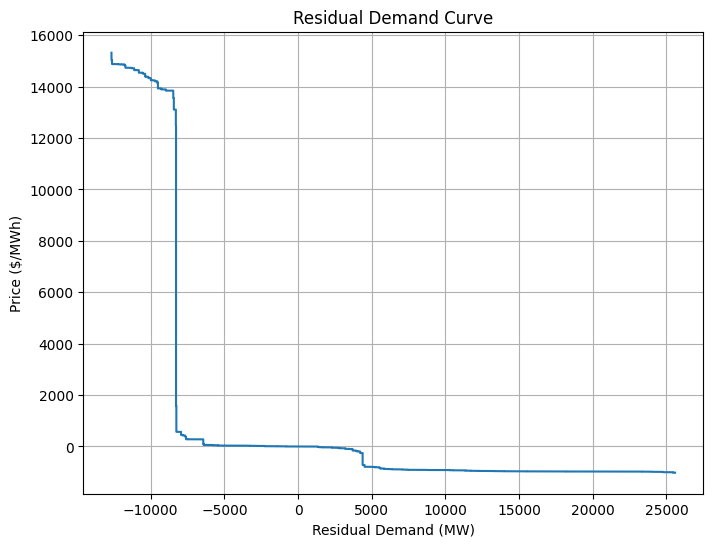

In [104]:
plt.figure(figsize=(8, 6))
plt.step(
    rival_grouped_df["RESIDUAL_DEMAND"],  # X-axis
    rival_grouped_df["PRICE"],           # Y-axis
    where='post'
)

plt.xlabel("Residual Demand (MW)")
plt.ylabel("Price ($/MWh)")
plt.title("Residual Demand Curve")
plt.grid(True)
plt.show()

## Plotting firm i's supply bid function, firm i's residual demand, and the marginal cost

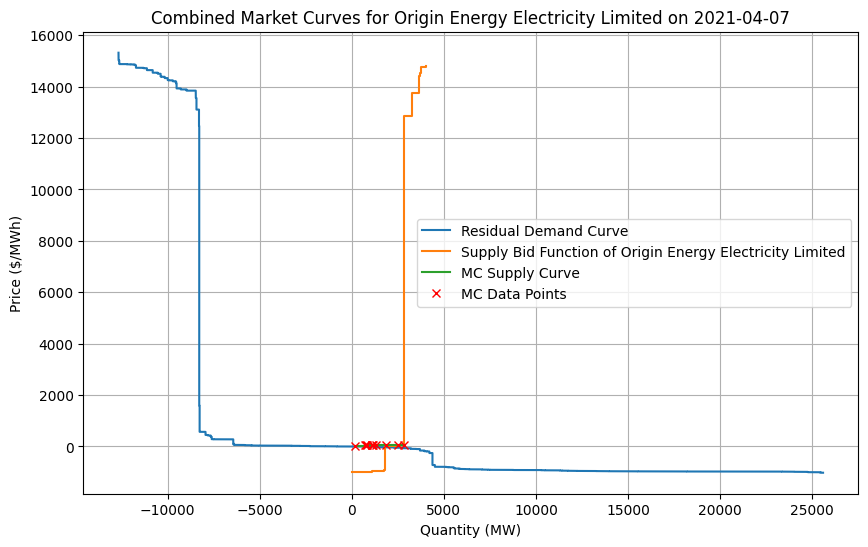

In [120]:
plt.figure(figsize=(10, 6))

# 1. Plot the Residual Demand Curve (step plot)
plt.step(
    rival_grouped_df["RESIDUAL_DEMAND"],  # X-axis for residual demand
    rival_grouped_df["PRICE"],            # Y-axis for residual demand
    where='post',
    label="Residual Demand Curve"
)

# 2. Plot firm i's Supply Bid Function (step plot)
plt.step(
    firm_i_df["FIRM_CUMULATIVE_VOLUME"],  # X-axis for supply bid
    firm_i_df["PRICE"],                   # Y-axis for supply bid
    where='post',
    label=f"Supply Bid Function of {firm_i}"
)

# 3. Plot the MC Supply Curve (step plot) with data points
plt.step(
    dispatch_df_time_date_company['CumulativeCapacity'], 
    dispatch_df_time_date_company['AU$/MWh'], 
    where='post',
    label="MC Supply Curve"
)
plt.plot(
    dispatch_df_time_date_company['CumulativeCapacity'], 
    dispatch_df_time_date_company['AU$/MWh'],
    linestyle="None",   # No connecting lines, only markers
    marker="x",
    color="red",
    label="MC Data Points"
)

# Label the axes and title
plt.xlabel("Quantity (MW)")
plt.ylabel("Price ($/MWh)")  # Adjust the units if necessary
plt.title(f"Combined Market Curves for {firm_i} on {date}")

# Add legend and grid
plt.legend()
plt.grid(True)

plt.show()

## A test is to intersect the inelastic demand and the overall market supply function
I believe the above graph is currently wrong

In [126]:
firm_aggregated_bids

,Participant,SETTLEMENTDATE,PRICE,VOLUME,FIRM_CUMULATIVE_VOLUME,TOTAL_CUMULATIVE_VOLUME
0,AGL Hydro Partnership,2021-04-07,-1002.40,0.0,0.0,0.0
1,AGL Hydro Partnership,2021-04-07,-990.30,0.0,0.0,0.0
2,AGL Hydro Partnership,2021-04-07,-985.40,0.0,0.0,0.0
3,AGL Hydro Partnership,2021-04-07,-984.16,0.0,0.0,0.0
4,AGL Hydro Partnership,2021-04-07,-975.70,408.0,408.0,408.0
...,...,...,...,...,...,...
95,AGL Macquarie Pty Limited,2021-04-07,277.20,0.0,1660.0,5011.0
96,AGL Macquarie Pty Limited,2021-04-07,462.00,0.0,1660.0,5011.0
97,AGL Macquarie Pty Limited,2021-04-07,462.38,0.0,1660.0,5011.0
98,AGL Macquarie Pty Limited,2021-04-07,12608.75,0.0,1660.0,5011.0


In [135]:
# Select only the needed columns
df = firm_aggregated_bids[["SETTLEMENTDATE", "PRICE", "VOLUME"]].copy()

# Sort by SETTLEMENTDATE and PRICE (ascending order)
df = df.sort_values(["SETTLEMENTDATE", "PRICE"], ascending=[True, True])

df = df[df["VOLUME"] != 0]

# Recalculate cumulative volume for each date
df["CUMULATIVE_VOLUME"] = df.groupby("SETTLEMENTDATE")["VOLUME"].cumsum()

pd.set_option("display.max_rows", None)
display(df)  # or simply: df

,SETTLEMENTDATE,PRICE,VOLUME,CUMULATIVE_VOLUME
1603,2021-04-07,-1021.10,4.0,4.0
148,2021-04-07,-1017.30,106.0,110.0
1604,2021-04-07,-1011.30,4.0,114.0
378,2021-04-07,-1009.64,57.0,171.0
1749,2021-04-07,-1001.51,106.0,277.0
1798,2021-04-07,-1001.30,95.0,372.0
1605,2021-04-07,-1000.50,6.0,378.0
102,2021-04-07,-999.80,120.0,498.0
1377,2021-04-07,-998.70,333.0,831.0
1606,2021-04-07,-993.50,4.0,835.0


In [132]:
# Find the first row where the cumulative volume meets or exceeds the inelastic demand
try:
    mc_row = df[df["CUMULATIVE_VOLUME"] >= inelastic_demand].iloc[0]
    market_clearing_price = mc_row["PRICE"]
    print("Market Clearing Price:", market_clearing_price)
except IndexError:
    print("Inelastic demand exceeds the total cumulative volume. Check your data.")

Market Clearing Price: -34.99


In [133]:
result_row = df[df["PRICE"] == -34.99]
print(result_row)

    SETTLEMENTDATE  PRICE  VOLUME  CUMULATIVE_VOLUME
160     2021-04-07 -34.99   234.0            25661.0


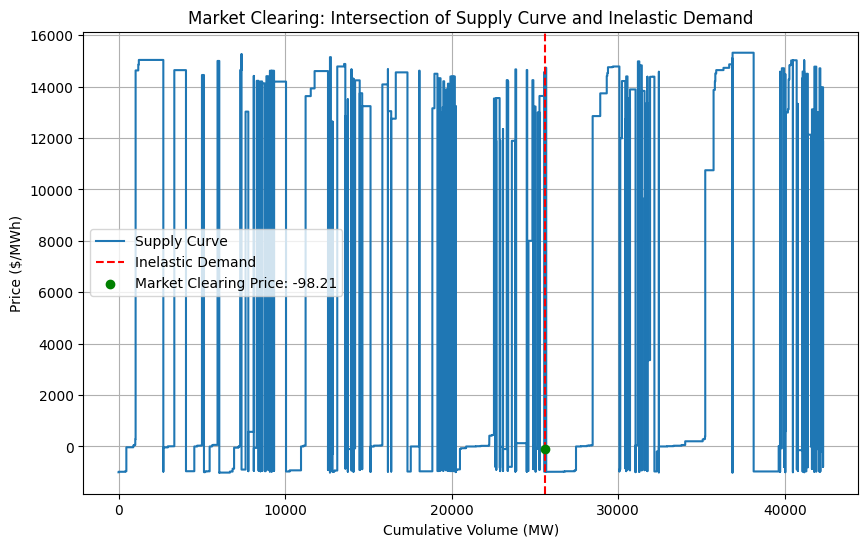

In [129]:
# 2. Create the Plot:
plt.figure(figsize=(10, 6))

# Plot the aggregated supply curve as a step function:
plt.step(
    firm_aggregated_bids["TOTAL_CUMULATIVE_VOLUME"],  # X-axis: cumulative volume
    firm_aggregated_bids["PRICE"],                      # Y-axis: bid price
    where='post',
    label="Supply Curve"
)

# Plot the inelastic demand line (vertical line):
plt.axvline(
    x=inelastic_demand, 
    color="red", 
    linestyle="--", 
    label="Inelastic Demand"
)

# Mark the intersection (market clearing point) with a marker:
plt.scatter(
    [inelastic_demand], 
    [market_clearing_price], 
    color="green", 
    zorder=5, 
    label=f"Market Clearing Price: {market_clearing_price:.2f}"
)

# Label the axes and add a title:
plt.xlabel("Cumulative Volume (MW)")
plt.ylabel("Price ($/MWh)")
plt.title("Market Clearing: Intersection of Supply Curve and Inelastic Demand")

# Add a legend and grid for clarity:
plt.legend()
plt.grid(True)
plt.show()

## What do I notice
Need to truncate the residual demand to what is the capacity of firm i

## Price Data

In [139]:
# Get the price bids.
price_data = dynamic_data_compiler(start_time='2021/03/01 00:00:00',
                                   end_time='2021/04/10 00:00:00',
                                   table_name='DISPATCHPRICE',
                                   raw_data_location=raw_data_cache)

INFO: Compiling data for table DISPATCHPRICE
INFO: Returning DISPATCHPRICE.


In [141]:
price_data.head()

,SETTLEMENTDATE,REGIONID,INTERVENTION,RRP,RAISE6SECRRP,RAISE60SECRRP,RAISE5MINRRP,RAISEREGRRP,LOWER6SECRRP,LOWER60SECRRP,LOWER5MINRRP,LOWERREGRRP,PRICE_STATUS
0,2021-03-01 00:05:00,NSW1,0,36.23968,1.73,3.04743,0.88,12.75,0.99,1.81,0.2,9.52011,FIRM
1,2021-03-01 00:05:00,QLD1,0,43.72986,1.73,3.04743,0.88,12.75,0.99,1.81,0.2,9.52011,FIRM
2,2021-03-01 00:05:00,SA1,0,72.31011,1.73,3.04743,0.88,12.75,0.99,0.00,0.0,9.32011,FIRM
3,2021-03-01 00:05:00,TAS1,0,27.63901,4.98,7.74543,0.90,12.77,0.99,0.44,0.2,9.52011,FIRM
4,2021-03-01 00:05:00,VIC1,0,20.95000,1.73,3.04743,0.88,12.75,0.99,1.81,0.2,9.52011,FIRM


In [142]:
date

'2021-04-07'

In [143]:
test = price_data[price_data['SETTLEMENTDATE'] == '2021-04-07 18:05:00']
test 

,SETTLEMENTDATE,REGIONID,INTERVENTION,RRP,RAISE6SECRRP,RAISE60SECRRP,RAISE5MINRRP,RAISEREGRRP,LOWER6SECRRP,LOWER60SECRRP,LOWER5MINRRP,LOWERREGRRP,PRICE_STATUS
9720,2021-04-07 18:05:00,NSW1,0,299.99000,110.34188,51.00,0.88,89.71339,0.03,0.38,0.18,3.99,FIRM
9721,2021-04-07 18:05:00,QLD1,0,458.92354,110.34188,51.00,0.88,89.71339,0.03,0.38,0.18,3.99,FIRM
9722,2021-04-07 18:05:00,SA1,0,315.75693,110.34188,51.00,0.88,89.71339,0.03,0.38,0.18,3.99,FIRM
9723,2021-04-07 18:05:00,TAS1,0,26.26000,1.45000,1.73,0.00,1.85000,0.03,0.38,0.18,3.99,FIRM
9724,2021-04-07 18:05:00,VIC1,0,293.11187,110.34188,51.00,0.88,89.71339,0.03,0.38,0.18,3.99,FIRM


## Thoughts

Completely out of whack with the market clearing price I previously calculated

In [ ]:
# Find all bids for the 6:00-6:05pm interval
# INTERVAL_DATETIME in the bids data indicates the start of the 5-minute interval that the bids apply to
# We need to take the total demand and minus all the other rival bids. 
# If this is happening at a firm level, then that needs to be automated before moving on 
# so we need to find all the firm's supply bids or just do 

all_bids_for_single_day_auction = bids_with_duid[bids_with_duid['INTERVAL_DATETIME']  == '2021-04-09 18:00:00'] 
all_bids_for_single_day_auction